**INSTALLATION OF USEFUL LIBRARIES**

In [ ]:
!pip install hexdump

  Preparing metadata (setup.py) ... done
  Created wheel for hexdump: filename=hexdump-3.3-py3-none-any.whl size=8894 sha256=ee0956883bfd51749330570db2b3dad1c5e93834caddb0090f7040859f31d275
  Stored in directory: /root/.cache/pip/wheels/26/28/f7/f47d7ecd9ae44c4457e72c8bb617ef18ab332ee2b2a1047e87
Successfully built hexdump


**IMPORT OF THE LIBRARIES**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from sklearn.utils import class_weight
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from locale import normalize
import re
import hexdump
import os
from os import listdir
import cv2
from ipywidgets import widgets
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET AND DATA GENERATION

In [ ]:
#paths to the directories of training and validation set and test set
origin = ('/content/drive/MyDrive/datadeep/training')
test_directory= ('/content/drive/MyDrive/datadeep/test')

#declaration of size of the images and number of epochs for the training step
img_height = 64
img_width = 64
epochs = 25

In [ ]:
#checkbox to select some specific classes of animals
class_names = ['badger', 'boar', 'deer', 'fox', 'hare', 'hedgehog', 'horse', 'squirrel', 'woodpigeon']
checkboxes = []
for item in class_names:
    checkbox = widgets.Checkbox(description=item, value=True)
    checkboxes.append(checkbox)

widgets.VBox(checkboxes)

In [ ]:
#images generator

#step useful for the data augmentation (only for the training and the validation)
gen = ImageDataGenerator(
     brightness_range = [0.8,1.3],
     horizontal_flip=True,
     shear_range=0.4,
     rotation_range=20,
     vertical_flip=False,
     validation_split=0.1
     )

#for the test dataset we use a different image data generator because we don't need data augmentation
testgen =  ImageDataGenerator(

     )


selected_classes = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        selected_classes = selected_classes + [checkboxes[i].description]
print(selected_classes)



train = gen.flow_from_directory(
    classes = selected_classes,
    directory=origin,
    target_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=8,
    class_mode="sparse",
    subset='training',
    shuffle=True
)
valid = gen.flow_from_directory(
    classes = selected_classes,
    directory=origin,
    target_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=2,
    class_mode="sparse",
    subset='validation',
    shuffle=True,
    seed=42
)

test = testgen.flow_from_directory(
    classes = selected_classes,
    directory=test_directory,
    target_size=(img_height, img_width),
    color_mode="grayscale",
    batch_size=1,
    class_mode="sparse",
    shuffle=False,
    seed=42
)

['badger', 'boar', 'deer', 'hare', 'hedgehog', 'horse', 'woodpigeon']
Found 5190 images belonging to 7 classes.
Found 573 images belonging to 7 classes.
Found 1440 images belonging to 7 classes.


In [ ]:
#Definition of the dataset for arduino quantization
repre = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/datadeep/rep_dataset',
    color_mode='grayscale',
    image_size=(img_height, img_width),
)

Found 335 files belonging to 1 classes.


In [ ]:
#Showing some images in the dataset after data augmentation
x,y = train.next()
plt.figure(figsize=(10, 10))
inv_dict = {v: k for k, v in train.class_indices.items()}
for i in range(8):
 image = x[i]
 label = inv_dict[np.round(y[i])]
 ax = plt.subplot(3, 3, i + 1)

 plt.imshow(image,vmin=0, vmax =255, cmap = 'gray')
 plt.title(label)
 plt.axis("off")

In [ ]:
#Since the classes are not balanced, we need to compute the weigth of each class wrt the entire dataset
classes_weight = class_weight.compute_class_weight('balanced',classes = np.unique(train.classes),y=train.classes)

weights_dict = {i:w for i,w in enumerate(classes_weight)}

print(weights_dict)

**MODEL**

In [ ]:
#definition of the model
model = Sequential([
      layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
      layers.MaxPooling2D(padding ='same'),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(padding ='same'),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(padding ='same'),
      layers.Flatten(),
      layers.Dropout(0.4),
      layers.Dense(len(class_names))
    ])
model.summary()

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/checkpoint/'

#function for the adaptive learning rate
redlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3, min_lr=0.000005
    )
early = tf.keras.callbacks.EarlyStopping(monitor='val_Accuracy', mode='max', patience=10)


#useful for saving the model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_Accuracy',
    mode='max',
    save_best_only=True)

#optimizer and loss definition
opt = keras.optimizers.Adam(learning_rate=0.0005, weight_decay = 0.1)
kloss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits='true')
model.compile(optimizer=opt, loss=kloss, metrics=['Accuracy'])

**TRAINING AND TEST PHASES**

In [ ]:
#training step
history = model.fit(train,
                    epochs=epochs,
                    shuffle =True,
                    validation_data=valid,
                    class_weight=weights_dict,
                    callbacks = [checkpoint_callback, redlr]
                    )

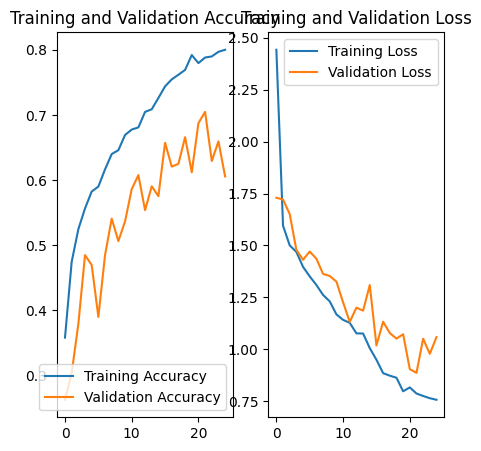

In [ ]:
#Plot the graphs for accuracy
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Altro/cinque.hdf5')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/gray64_acc80.hdf5')

**RESULTS**

In [ ]:
#evaluation of the model on the test dataset
results = model.evaluate(test)
print("test loss, test acc:", results)

In [ ]:
#saving the results on file
f = open("/content/drive/MyDrive/results/result.txt", "a")
res = f"Size: {img_height} x {img_width}---- Validation Accuracy: {max(history.history['val_Accuracy'])} -----Test Accuracy: {results[1]} ----N.Classes: {len(selected_classes)}\n"
f.write(res)
f.close()

In [ ]:
#predictions of the model over the testset
preds = model.predict(test)
y_pred = []
y_pred.append(np.argmax(preds, axis = - 1))

In [ ]:
#confusion matrix computation and plotting metrics
cm = confusion_matrix(test.classes, y_pred[0], normalize = 'true')
print(classification_report(test.classes, y_pred[0], target_names = selected_classes))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels = selected_classes)
fig, ax = plt.subplots(figsize=(8,8))
cm_display.plot(ax=ax)
plt.show()

In [ ]:


#Rapresentative dataset to balance input for model quantization
def repr_data_gen():
  for e, _ in repre.take(8):
    for i in range(e.shape[0]):
      img = e[i, :]
      img = np.expand_dims(img,0).astype(np.float32)
      yield [img]

In [ ]:
#function to port the model from a standard TF model to a quantized int8_t model readable by Arduino (file .h)
def porta(model, optimize=True, variable_name='model_data', pretty_print=False):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimize:
        if isinstance(optimize, bool):
            optimizers = [tf.lite.Optimize.DEFAULT]
        else:
            optimizers = optimize
        converter.representative_dataset = repr_data_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8  # or tf.uint8
        converter.inference_output_type = tf.int8  # or tf.uint8
        converter.optimizations = optimizers
    tflite_model = converter.convert()
    tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)
    bytes = hexdump.dump(tflite_model).split(' ')
    c_array = ', '.join(['0x%02x' % int(byte, 16) for byte in bytes])
    c = 'const unsigned char %s[] DATA_ALIGN_ATTRIBUTE = {%s};' % (variable_name, c_array)
    if pretty_print:
        c = c.replace('{', '{\n\t').replace('}', '\n}')
        c = re.sub(r'(0x..?, ){12}', lambda x: '%s\n\t' % x.group(0), c)
    c += '\nconst int %s_len = %d;' % (variable_name, len(bytes))
    preamble = '''
#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned) || (defined(__GNUC__) && !defined(__clang__))
#define DATA_ALIGN_ATTRIBUTE __attribute__((aligned(4)))
#else
#define DATA_ALIGN_ATTRIBUTE
#endif

'''
    return preamble + c

In [ ]:
#creation of the model .h (Arduino TensorFlow model)
cpp_code  = porta(model, variable_name='semibig', pretty_print=True, optimize=True)
with open('/content/semibig.h', 'w') as writefile:
    writefile.write(cpp_code)


In [ ]:
#test the results on new image
from matplotlib import pyplot

image_path ='/content/fox.jpg'
img = tf.keras.utils.load_img(image_path, color_mode = 'grayscale', target_size = (img_height,img_width))
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array,cmap = 'gray', vmax = 255)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array.shape

predictions = model.predict(img_array)
print(predictions)
print(class_names)
score = tf.nn.softmax(predictions[0])
print(score*100)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
#function useful for the plot of the different step of the convolution
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
#Shows the different steps of the model computation for the classification
np.seterr(divide='ignore', invalid='ignore')
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)



                       # Numpy array with shape (150, 150, 3)
x   =img_array                  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )